# 02 - Data Cleaning
## Echelon: Enterprise Privileged Access Governance System

**Purpose:** Apply systematic cleaning to raw access logs and document every decision with visual evidence.

**Input:** `data/raw/enterprise_privileged_access_logs.csv`  
**Output:** `data/processed/cleaned_access_logs.csv`

**Cleaning Steps:**
1. Load raw data
2. Handle missing values (role-specific median imputation)
3. Standardize columns (names, casing, types)
4. Remove duplicates (post-standardization)
5. Validate cleaned data
6. Save and summarize

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Add project root to path
sys.path.append(str(Path.cwd().parent))

from src.data.clean_data import (
    load_raw_data,
    handle_missing_values,
    standardize_columns,
    remove_duplicates,
    save_cleaned_data,
    generate_cleaning_summary
)
from src.data.validate_data import validate_cleaned_data

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("Imports successful")

Imports successful


---
## Section 1: Load Raw Data

In [24]:
raw_file = Path("../data/raw/enterprise_privileged_access_logs.csv")

df_raw = load_raw_data(raw_file)
df_before = df_raw.copy()  # Preserve original for comparison

df_raw.head()

 ECHELON - DATA CLEANING PIPELINE

[1/6] Loading raw data from: ..\data\raw\enterprise_privileged_access_logs.csv
  Loaded 12,918 records
  Shape: (12918, 10)
  Memory: 3.4 MB



,user_id,role,resource_type,action,timestamp,session_duration,access_volume,success_flag,assigned_resource_count,actively_used_resource_count
0,USER_045,Cloud_Admin,gcp_console,read,2024-01-01 00:35:20,42.0,17.0,True,9,8
1,USER_055,Cloud_Admin,iam_console,write,2024-01-01 00:57:24,57.0,14.0,True,7,5
2,USER_064,Security_Admin,firewall_portal,write,2024-01-01 01:32:34,61.0,20.0,True,7,5
3,USER_024,HR_Admin,TIME_TRACKING,read,2024-01-01 01:54:39,31.0,7.0,True,5,4
4,USER_044,Cloud_Admin,gcp_console,Export,2024-01-01 02:38:32,75.0,16.0,True,9,7


---
## Section 2: Missing Value Analysis & Imputation

**Strategy:** Role-specific median imputation  
**Why not global median?** Each role has fundamentally different behavior baselines:
- DB_Admin sessions average ~65 min; HR_Admin ~35 min
- Imputing HR_Admin nulls with a global median inflated by DB_Admin values would distort role patterns

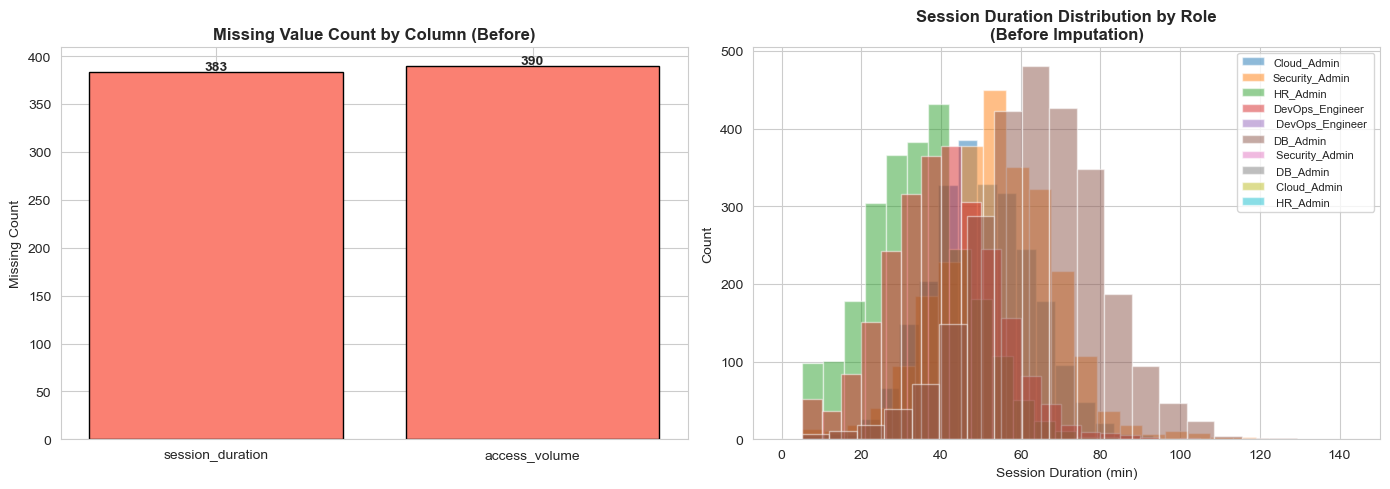


Missing value summary:
session_duration    383
access_volume       390
dtype: int64


In [25]:
# --- Before imputation ---
missing_before = df_raw.isnull().sum()
missing_before = missing_before[missing_before > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: missing count by column
axes[0].bar(missing_before.index, missing_before.values, color='salmon', edgecolor='black')
axes[0].set_title('Missing Value Count by Column (Before)', fontweight='bold')
axes[0].set_ylabel('Missing Count')
for i, v in enumerate(missing_before.values):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Right: session_duration distribution by role (with nulls excluded)
for role in df_raw['role'].dropna().unique():
    role_data = df_raw[df_raw['role'].str.strip() == role]['session_duration'].dropna()
    axes[1].hist(role_data, bins=20, alpha=0.5, label=role)

axes[1].set_title('Session Duration Distribution by Role\n(Before Imputation)', fontweight='bold')
axes[1].set_xlabel('Session Duration (min)')
axes[1].set_ylabel('Count')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.savefig('../outputs/figures/eda_raw/missing_values_before.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMissing value summary:")
print(df_raw.isnull().sum()[df_raw.isnull().sum() > 0])

In [26]:
df = handle_missing_values(df_raw.copy())

# Role-specific medians for annotation
print("Role-specific medians used for imputation:")
print("\nsession_duration medians:")
print(df_raw.groupby(df_raw['role'].str.strip())['session_duration'].median().round(1))
print("\naccess_volume medians:")
print(df_raw.groupby(df_raw['role'].str.strip())['access_volume'].median().round(1))

# Confirm no nulls remain
print(f"\nMissing values after imputation: {df.isnull().sum().sum()}")

[2/6] Handling missing values...
  Missing values before: 773
    ├─ Cloud_Admin: filled 84 nulls with median=50.0
    ├─ Security_Admin: filled 69 nulls with median=54.0
    ├─ HR_Admin: filled 72 nulls with median=34.0
    ├─ DevOps_Engineer: filled 81 nulls with median=40.0
    ├─ DB_Admin: filled 77 nulls with median=65.0
    ├─ Cloud_Admin: filled 70 nulls with median=20.0
    ├─ Security_Admin: filled 75 nulls with median=19.0
    ├─ HR_Admin: filled 71 nulls with median=8.0
    ├─ DevOps_Engineer: filled 85 nulls with median=26.0
    ├─ DB_Admin: filled 89 nulls with median=15.0
  Missing values after: 0

Role-specific medians used for imputation:

session_duration medians:
role
Cloud_Admin        50.0
DB_Admin           65.0
DevOps_Engineer    40.0
HR_Admin           34.0
Security_Admin     54.0
Name: session_duration, dtype: float64

access_volume medians:
role
Cloud_Admin        20.0
DB_Admin           15.0
DevOps_Engineer    26.0
HR_Admin            8.0
Security_Admin     19

---
## Section 3: Column Standardization

**Issues found in EDA:**
- ~5% of `role` values had leading/trailing whitespace
- ~8% of `action` values had mixed casing (e.g., `Read`, `READ`)
- ~10% of `resource_type` values were uppercase
- `success_flag` stored as object, needs boolean conversion

**Order matters:** Standardization runs BEFORE duplicate removal so that rows differing only by casing or whitespace are correctly identified as duplicates.

In [27]:
# Show before
print("BEFORE standardization:")
print(f"  action unique values: {sorted(df['action'].dropna().unique())}")
print(f"  resource_type sample: {df['resource_type'].dropna().unique()[:5]}")
print(f"  success_flag dtype: {df['success_flag'].dtype}")

df = standardize_columns(df)

# Show after
print("\nAFTER standardization:")
print(f"  action unique values: {sorted(df['action'].unique())}")
print(f"  resource_type sample: {df['resource_type'].unique()[:5]}")
print(f"  success_flag dtype: {df['success_flag'].dtype}")

BEFORE standardization:
  action unique values: ['Delete', 'Export', 'Read', 'Write', 'delete', 'export', 'read', 'write']
  resource_type sample: ['gcp_console' 'iam_console' 'firewall_portal' 'TIME_TRACKING'
 'storage_buckets']
  success_flag dtype: bool
[4/6] Standardizing column names and values...
  Column names standardized
  role column stripped (unique values: 5)
  action column normalized (unique values: 4)
  resource_type column normalized (unique values: 60)
  success_flag converted to bool


AFTER standardization:
  action unique values: ['delete', 'export', 'read', 'write']
  resource_type sample: ['gcp_console' 'iam_console' 'firewall_portal' 'time_tracking'
 'storage_buckets']
  success_flag dtype: bool


---
## Section 4: Duplicate Removal

Duplicates are log replay artifacts — the same event recorded twice. Running this **after standardization** ensures rows that differed only by casing (e.g., `Read` vs `read`) are also caught.

[3/6] Removing duplicate rows...
  Duplicates found: 253 (1.96%)
  Rows before: 12,918
  Rows after: 12,665
  Rows removed: 253



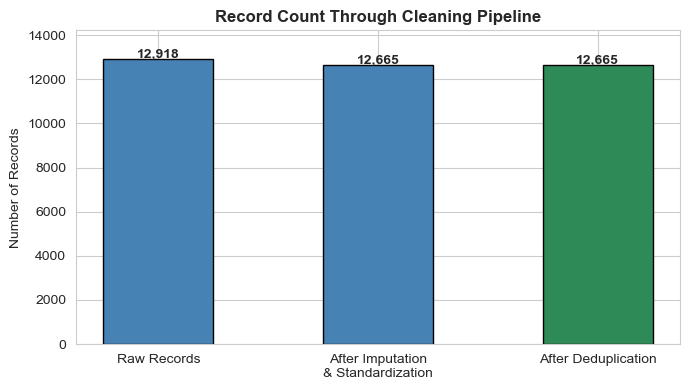


Duplicates removed: 253
Final record count: 12,665


In [28]:
dupes_before = df.duplicated().sum()
df = remove_duplicates(df)

# Bar chart: before vs after
fig, ax = plt.subplots(figsize=(7, 4))
counts = [len(df_before), len(df_before) - dupes_before, len(df)]
labels = ['Raw Records', 'After Imputation\n& Standardization', 'After Deduplication']
colors = ['steelblue', 'steelblue', 'seagreen']

bars = ax.bar(labels, counts, color=colors, edgecolor='black', width=0.5)
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{count:,}', ha='center', fontweight='bold')

ax.set_title('Record Count Through Cleaning Pipeline', fontweight='bold')
ax.set_ylabel('Number of Records')
ax.set_ylim(0, max(counts) * 1.1)
plt.tight_layout()
plt.savefig('../outputs/figures/eda_raw/cleaning_pipeline_counts.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nDuplicates removed: {dupes_before}")
print(f"Final record count: {len(df):,}")

---
## Section 5: Post-Cleaning Validation

In [29]:
validation_passed = validate_cleaned_data(df)

if not validation_passed:
    print("⚠ Review validation issues before proceeding.")

[5/6] Validating cleaned data...
  No missing values
  No duplicate rows
  Timestamp range valid (2024)
  All 5 roles present
  Value ranges valid
  All action types valid

  All validation checks passed!


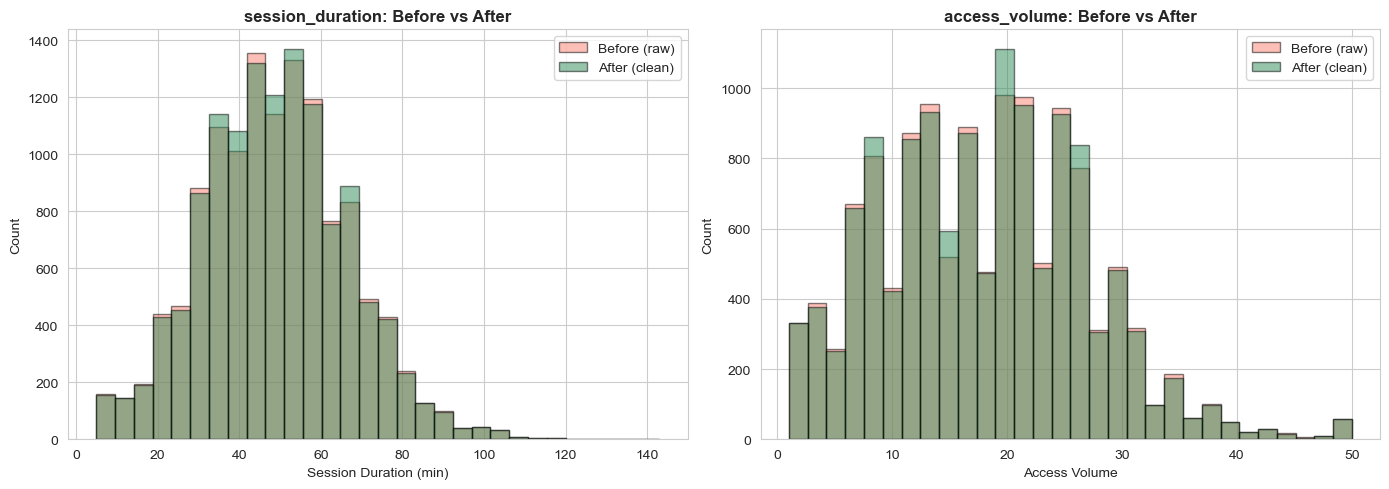

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# session_duration: before vs after
axes[0].hist(df_before['session_duration'].dropna(), bins=30, alpha=0.5,
             color='salmon', edgecolor='black', label='Before (raw)')
axes[0].hist(df['session_duration'], bins=30, alpha=0.5,
             color='seagreen', edgecolor='black', label='After (clean)')
axes[0].set_title('session_duration: Before vs After', fontweight='bold')
axes[0].set_xlabel('Session Duration (min)')
axes[0].set_ylabel('Count')
axes[0].legend()

# access_volume: before vs after
axes[1].hist(df_before['access_volume'].dropna(), bins=30, alpha=0.5,
             color='salmon', edgecolor='black', label='Before (raw)')
axes[1].hist(df['access_volume'], bins=30, alpha=0.5,
             color='seagreen', edgecolor='black', label='After (clean)')
axes[1].set_title('access_volume: Before vs After', fontweight='bold')
axes[1].set_xlabel('Access Volume')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/figures/eda_raw/before_after_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

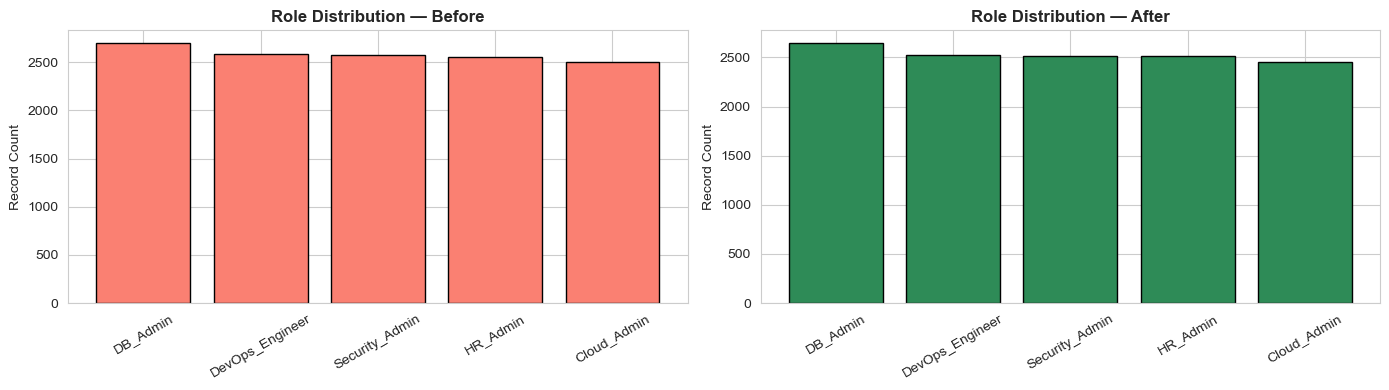

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

role_before = df_before['role'].str.strip().value_counts()
role_after = df['role'].value_counts()

axes[0].bar(role_before.index, role_before.values, color='salmon', edgecolor='black')
axes[0].set_title('Role Distribution — Before', fontweight='bold')
axes[0].set_ylabel('Record Count')
axes[0].tick_params(axis='x', rotation=30)

axes[1].bar(role_after.index, role_after.values, color='seagreen', edgecolor='black')
axes[1].set_title('Role Distribution — After', fontweight='bold')
axes[1].set_ylabel('Record Count')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('../outputs/figures/eda_raw/role_distribution_before_after.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 6: Save Cleaned Data & Summary Report

In [32]:
clean_file = Path("../data/processed/cleaned_access_logs.csv")
report_dir = Path("../outputs/reports")

save_cleaned_data(df, clean_file)
generate_cleaning_summary(df_before, df, report_dir)

print("Cleaned data saved.")
print("Summary report saved.")

[6/6] Saving cleaned data to: ..\data\processed\cleaned_access_logs.csv
  Saved 12,665 records
  File size: 1014.3 KB

  Summary report saved to: ..\outputs\reports\cleaning_summary.md
Cleaned data saved.
Summary report saved.


---
## Summary

| Step | Action | Impact |
|------|--------|--------|
| Missing Values | Role-specific median imputation | 773 nulls filled, 0 remaining |
| Standardization | Lowercase, strip whitespace, bool conversion | Consistent categories, 0 formatting issues |
| Deduplication | Drop exact duplicates (post-standardization) | 253 rows removed (1.96%) |
| **Final Dataset** | **12,665 records, 10 columns** | **100% complete, no duplicates** |